In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import scipy.stats as stats
from collections import Counter
import numpy as np

from utils import (
    get_runs, get_enemies
)

In [3]:
runs = get_runs()
enemies = get_enemies()

In [4]:
pivot_df = enemies.pivot_table(index='run_id', columns='nome', values='quantity', fill_value=0)
pivot_df = pivot_df.reset_index()

same_combinations = pivot_df.groupby(list(pivot_df.columns[1:]))['run_id'].apply(list).reset_index()
same_combinations = same_combinations[same_combinations['run_id'].map(len) > 1]

print(same_combinations.head())

   Enemy1  Enemy2  Enemy3                                             run_id
0     0.0     0.0     4.0  [6, 8, 9, 10, 14, 19, 22, 24, 51, 53, 57, 62, ...
1     0.0     0.0     6.0  [26, 31, 40, 43, 61, 133, 143, 185, 192, 193, ...
2     0.0     0.0     7.0                  [67, 91, 137, 139, 202, 267, 282]
3     0.0     1.0     3.0    [11, 54, 97, 114, 121, 162, 169, 218, 285, 299]
4     0.0     2.0     3.0                 [50, 120, 165, 167, 174, 180, 295]


In [5]:
data = []
mean_data = []

for idx, row in same_combinations.iterrows():
	indexes = row['run_id']

	df = runs.loc[runs['id'].isin(indexes)]

	#print(df[['is_completed', 'difficulty']])
	#print(df['difficulty'].unique())

	for difficulty in df['difficulty'].unique():
		df_difficulty = df[df['difficulty'] == difficulty]
		for _, run_row in df_difficulty.iterrows():
			data.append({
				'idx': idx,
				'difficulty': difficulty,
				'lostLife': run_row['lostLife'],
				'time': run_row['time'],
				'completion_status': run_row['is_completed']})

		df_difficulty_not_completed = df_difficulty[df_difficulty['is_completed'] == 0]
		df_difficulty_completed = df_difficulty[df_difficulty['is_completed'] == 1]

		if df_difficulty_completed.shape[0] > 0:
			mean_data.append({
				'idx': idx,
				'difficulty': difficulty,
				'lostLife': df_difficulty_completed['lostLife'].mean(),
				'time': df_difficulty_completed['time'].mean(),
				'completion_status': True})
		
		if df_difficulty_not_completed.shape[0] > 0:
			mean_data.append({
				'idx': idx,
				'difficulty': difficulty,
				'lostLife': df_difficulty_not_completed['lostLife'].mean(),
				'time': df_difficulty_not_completed['time'].mean(),
				'completion_status': False})

df_data = pd.DataFrame(data)
df_data['difficulty_rounded'] = df_data['difficulty'].round(2)
df_mean_data = pd.DataFrame(mean_data)

In [6]:
data = []

for idx, row in same_combinations.iterrows():
    indexes = row['run_id']

    df = runs.loc[runs['id'].isin(indexes)]
    deaths = df[df['is_completed'] == 0]

    for difficulty in df['difficulty'].unique():
        num_deaths = deaths[deaths['difficulty'] == difficulty].shape[0]
        total_attempts = df[df['difficulty'] == difficulty].shape[0]

        if total_attempts > 1:
            mean_deaths = num_deaths / total_attempts
            data.append({'idx': idx, 'difficulty': difficulty, 'mean_deaths': mean_deaths})

df_death = pd.DataFrame(data)

In [24]:
def check_increasing_pattern(sub_df, column_name):
    sorted_df = sub_df.sort_values(by='difficulty')
    return sorted_df[column_name].is_monotonic_increasing

def check_decreasing_pattern(sub_df, column_name):
    sorted_df = sub_df.sort_values(by='difficulty')
    return sorted_df[column_name].is_monotonic_decreasing

def check_quasi_increasing_pattern(sub_df, column_name):
    sorted_df = sub_df.sort_values(by='difficulty')
    mean_deaths = sorted_df[column_name].values
    
    last_accepted = -1
    break_count = 0
    total_elements = len(mean_deaths)
    
    #print(sorted_df)
    #print()

    for value in mean_deaths:
        if value >= last_accepted:
            last_accepted = value
        elif value < last_accepted:
            break_count += 1

    limit = total_elements * 0.2
    return break_count <= limit

def find_break_points(sub_df, value_column):
    sorted_df = sub_df.sort_values(by='difficulty')
    values = sorted_df[value_column].values
    difficulties = sorted_df['difficulty'].values
    
    break_points = []
    last_accepted = -1
    
    for difficulty, value in zip(difficulties, values):
        if value >= last_accepted:
            last_accepted = value
        else:
            break_points.append(difficulty)
    
    return break_points

# Média de Mortes por Dificuldade

In [23]:
death_pattern_results = df_death.groupby('idx').apply(check_increasing_pattern, column_name='mean_deaths').reset_index()
death_pattern_results.columns = ['idx', 'follows_quasi_pattern']

#print(quasi_pattern_results)
print(death_pattern_results['follows_quasi_pattern'].value_counts())

follows_quasi_pattern
True     13
False    11
Name: count, dtype: int64


C:\Users\jonas\AppData\Local\Temp\ipykernel_18624\2676529005.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  death_pattern_results = df_death.groupby('idx').apply(check_increasing_pattern, column_name='mean_deaths').reset_index()


## Casos errados

In [ ]:
all_break_frequencies = defaultdict(float)

break_points_results = df_death.groupby('idx').apply(find_break_points, value_column='mean_deaths').reset_index()
break_points_results.columns = ['idx', 'break_points']

all_break_points = [point for sublist in break_points_results['break_points'] for point in sublist]
total_frequencies = Counter(df_death['difficulty'])
break_point_frequencies = Counter(all_break_points)

print(break_point_frequencies)

for difficulty, count in break_point_frequencies.items():
    all_break_frequencies[float(difficulty.round(2))] += count

Counter({np.float64(0.6666666865348816): 7, np.float64(0.5): 6, np.float64(1.0): 5, np.float64(0.3333333432674408): 1, np.float64(0.75): 1})


C:\Users\jonas\AppData\Local\Temp\ipykernel_18624\2983848248.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  break_points_results = df_death.groupby('idx').apply(find_break_points, value_column='mean_deaths').reset_index()


## Pie Plot

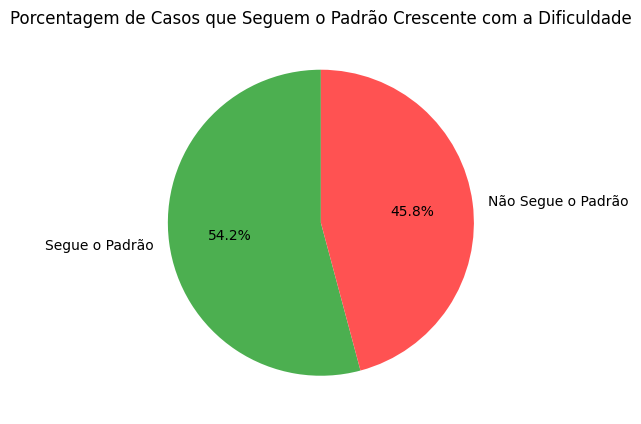

In [ ]:
pattern_counts = death_pattern_results['follows_quasi_pattern'].value_counts()
counts_ordered = [pattern_counts.get(True, 0), pattern_counts.get(False, 0)]

labels = ['Segue o Padrão', 'Não Segue o Padrão']
colors = ['#4CAF50', '#FF5252']
plt.figure(figsize=(6, 6))

plt.pie(counts_ordered, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Porcentagem de Casos que Seguem o Padrão Crescente com a Dificuldade')
plt.tight_layout()
plt.show()

## Densidade

C:\Users\jonas\AppData\Local\Temp\ipykernel_13380\2285981302.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df,


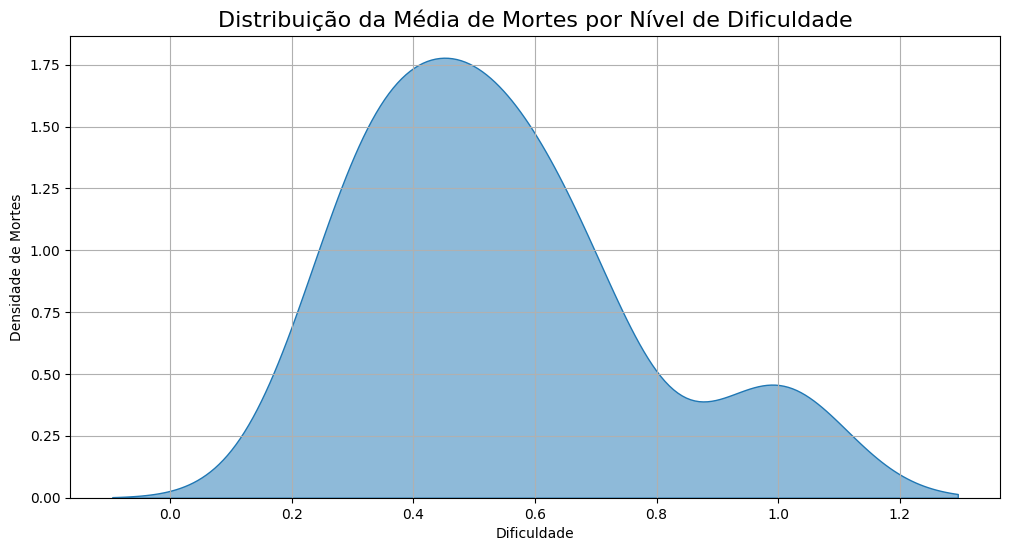

In [ ]:
def plot_death_mean_density(df, level=None):
	plt.figure(figsize=(12, 6))
	sns.kdeplot(data=df,
			x='difficulty', 
			weights='mean_deaths',
			fill=True,
			alpha=0.5,
			palette='deep',
			common_norm=False)

	plt.xlabel('Dificuldade')
	plt.ylabel('Densidade de Mortes')
	plt.grid()
	plt.title('Distribuição da Média de Mortes por Nível de Dificuldade', fontsize=16)
	#plt.savefig(f'{folder_path}/death_mean_difficulty.png', dpi=96, bbox_inches='tight')

	plt.show()

plot_death_mean_density(df_death)

# Vida perdida por dificuldade

In [28]:
lost_life_pattern_results = df_mean_data[df_mean_data['completion_status'] == False].groupby('idx').apply(check_increasing_pattern, column_name='lostLife').reset_index()
lost_life_pattern_results.columns = ['idx', 'follows_quasi_pattern']

lost_life_pattern_completed_results = df_mean_data[df_mean_data['completion_status'] == True].groupby('idx').apply(check_increasing_pattern, column_name='lostLife').reset_index()
lost_life_pattern_completed_results.columns = ['idx', 'follows_quasi_pattern']

print(lost_life_pattern_results['follows_quasi_pattern'].value_counts())
print(lost_life_pattern_completed_results['follows_quasi_pattern'].value_counts())

follows_quasi_pattern
False    12
True     10
Name: count, dtype: int64
follows_quasi_pattern
False    26
True      5
Name: count, dtype: int64


C:\Users\jonas\AppData\Local\Temp\ipykernel_18624\2127530842.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lost_life_pattern_results = df_mean_data[df_mean_data['completion_status'] == False].groupby('idx').apply(check_increasing_pattern, column_name='lostLife').reset_index()
C:\Users\jonas\AppData\Local\Temp\ipykernel_18624\2127530842.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lost_life_patt

## Casos errados

In [13]:
break_points_results = df_mean_data[df_mean_data['completion_status'] == False].groupby('idx').apply(find_break_points, value_column='lostLife').reset_index()
break_points_results.columns = ['idx', 'break_points']

all_break_points = [point for sublist in break_points_results['break_points'] for point in sublist]
total_frequencies = Counter(df_death['difficulty'])
break_point_frequencies = Counter(all_break_points)

print(break_point_frequencies)

for difficulty, count in break_point_frequencies.items():
    all_break_frequencies[float(difficulty.round(2))] += count

Counter({np.float64(0.6666666865348816): 6, np.float64(1.0): 6, np.float64(0.5): 4, np.float64(0.4000000059604645): 2, np.float64(0.75): 2, np.float64(0.800000011920929): 1, np.float64(0.3333333432674408): 1})


C:\Users\jonas\AppData\Local\Temp\ipykernel_18624\1129988034.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  break_points_results = df_mean_data[df_mean_data['completion_status'] == False].groupby('idx').apply(find_break_points, value_column='lostLife').reset_index()


## Pie Plot

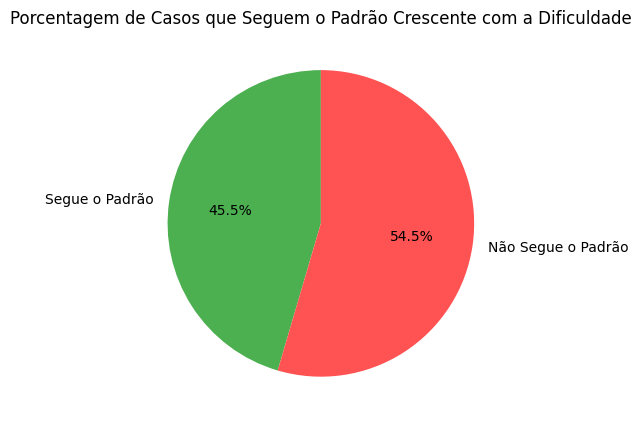

In [ ]:
pattern_counts = lost_life_pattern_results['follows_quasi_pattern'].value_counts()
counts_ordered = [pattern_counts.get(True, 0), pattern_counts.get(False, 0)]

labels = ['Segue o Padrão', 'Não Segue o Padrão']
colors = ['#4CAF50', '#FF5252']

plt.figure(figsize=(6, 6))
plt.pie(counts_ordered, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Porcentagem de Casos que Seguem o Padrão Crescente com a Dificuldade')
plt.tight_layout()
plt.show()

## Boxplot

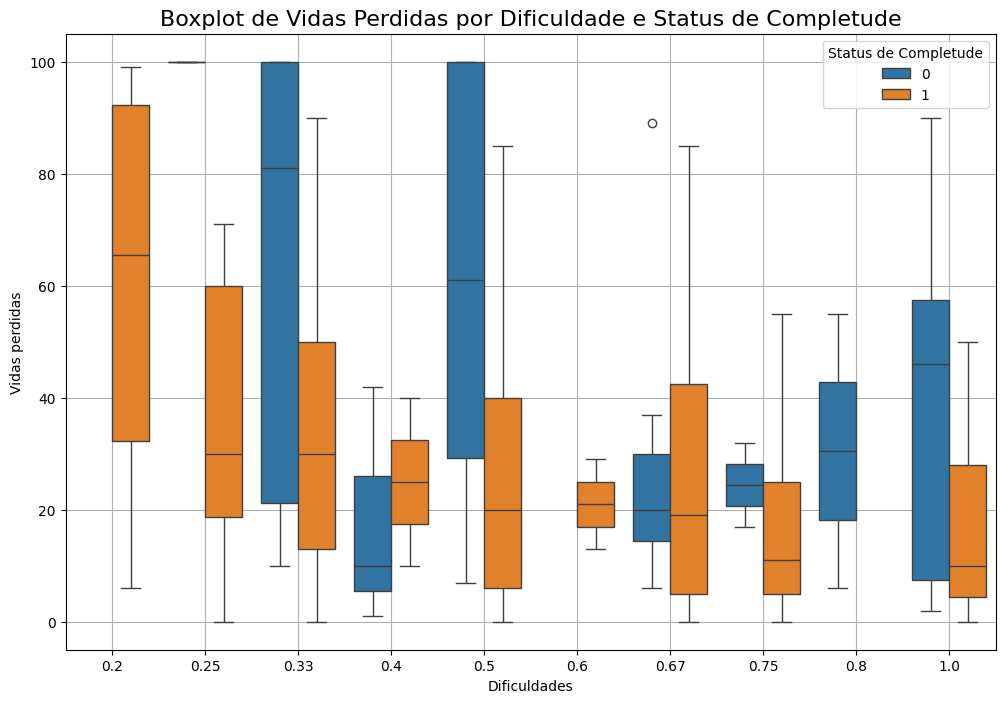

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='difficulty_rounded', y='lostLife', hue='completion_status', data=df_data, dodge=True)
plt.xlabel('Dificuldades')
plt.ylabel('Vidas perdidas')
plt.legend(title='Status de Completude')
plt.grid()
plt.title('Boxplot de Vidas Perdidas por Dificuldade e Status de Completude', fontsize=16)
plt.show()

# Tempo por dificuldade

In [30]:
time_pattern_results = df_mean_data[df_mean_data['completion_status'] == False].groupby('idx').apply(check_increasing_pattern, column_name='time').reset_index()
time_pattern_results.columns = ['idx', 'follows_quasi_pattern']

time_pattern_completed_results = df_mean_data[df_mean_data['completion_status'] == True].groupby('idx').apply(check_decreasing_pattern, column_name='time').reset_index()
time_pattern_completed_results.columns = ['idx', 'follows_quasi_pattern']

#print(quasi_pattern_results)
print(time_pattern_results['follows_quasi_pattern'].value_counts())
print(time_pattern_completed_results['follows_quasi_pattern'].value_counts())

follows_quasi_pattern
True     11
False    11
Name: count, dtype: int64
follows_quasi_pattern
False    25
True      6
Name: count, dtype: int64


C:\Users\jonas\AppData\Local\Temp\ipykernel_18624\3850342314.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_pattern_results = df_mean_data[df_mean_data['completion_status'] == False].groupby('idx').apply(check_increasing_pattern, column_name='time').reset_index()
C:\Users\jonas\AppData\Local\Temp\ipykernel_18624\3850342314.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_pattern_completed_

## Analisando os casos errados

In [14]:
break_points_results = df_mean_data[df_mean_data['completion_status'] == False].groupby('idx').apply(find_break_points, value_column='time').reset_index()
break_points_results.columns = ['idx', 'break_points']

all_break_points = [point for sublist in break_points_results['break_points'] for point in sublist]
total_frequencies = Counter(df_death['difficulty'])
break_point_frequencies = Counter(all_break_points)

print(break_point_frequencies)

for difficulty, count in break_point_frequencies.items():
    all_break_frequencies[float(difficulty.round(2))] += count

Counter({np.float64(0.6666666865348816): 5, np.float64(0.5): 4, np.float64(1.0): 4, np.float64(0.4000000059604645): 2, np.float64(0.3333333432674408): 1, np.float64(0.75): 1})


C:\Users\jonas\AppData\Local\Temp\ipykernel_18624\2589083808.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  break_points_results = df_mean_data[df_mean_data['completion_status'] == False].groupby('idx').apply(find_break_points, value_column='time').reset_index()


## Pie Plot

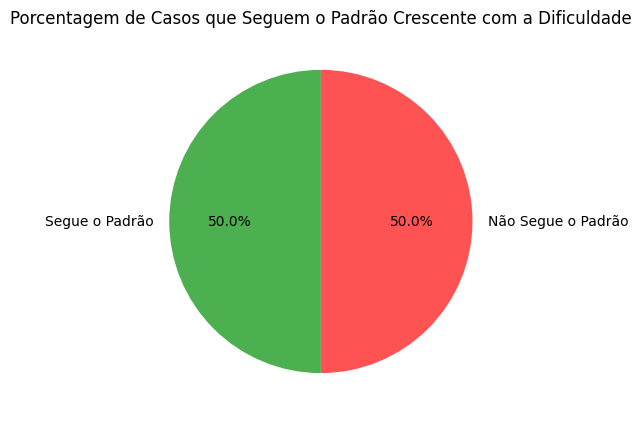

In [ ]:
pattern_counts = time_pattern_results['follows_quasi_pattern'].value_counts()
counts_ordered = [pattern_counts.get(True, 0), pattern_counts.get(False, 0)]

labels = ['Segue o Padrão', 'Não Segue o Padrão']
colors = ['#4CAF50', '#FF5252']

plt.figure(figsize=(6, 6))
plt.pie(counts_ordered, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Porcentagem de Casos que Seguem o Padrão Crescente com a Dificuldade')
plt.tight_layout()
plt.show()

## Boxplot

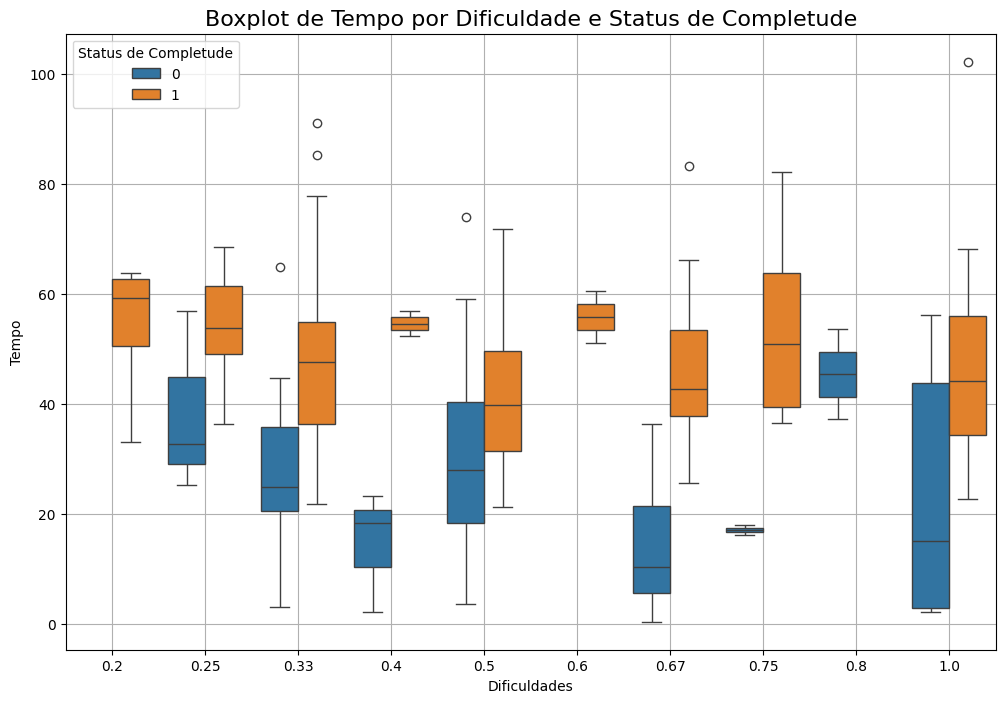

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='difficulty_rounded', y='time', hue='completion_status', data=df_data, dodge=True)
plt.xlabel('Dificuldades')
plt.ylabel('Tempo')
plt.legend(title='Status de Completude')
plt.grid()

plt.title('Boxplot de Tempo por Dificuldade e Status de Completude', fontsize=16)
plt.show()

# Quebras do padrão

Correlação de Pearson: 0.30


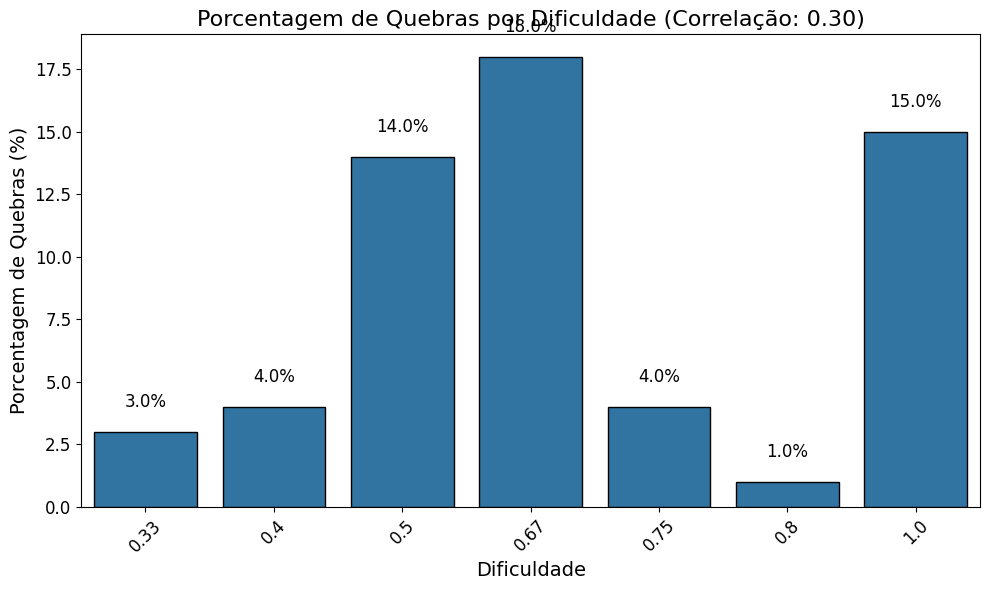

In [20]:
all_difficulties = list(all_break_frequencies.keys())
all_frequencies = list(all_break_frequencies.values())

total_frequencies_sum = sum(all_frequencies)

correlation, _ = stats.pearsonr(all_difficulties, all_frequencies)
print(f'Correlação de Pearson: {correlation:.2f}')

plt.figure(figsize=(10, 6))
sns.barplot(x=all_difficulties, y=all_frequencies, edgecolor="black")
plt.xlabel("Dificuldade", fontsize=14)
plt.ylabel("Porcentagem de Quebras (%)", fontsize=14)
plt.title(f"Porcentagem de Quebras por Dificuldade (Correlação: {correlation:.2f})", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

for i, bar in enumerate(plt.gca().patches):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.1f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

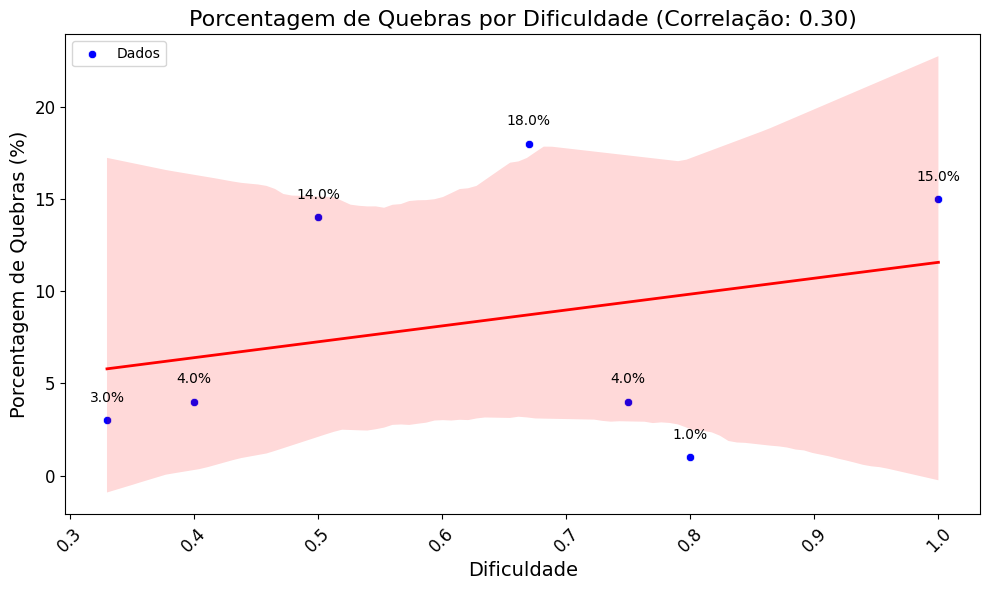

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_difficulties, y=all_frequencies, color='blue', label='Dados')
sns.regplot(x=all_difficulties, y=all_frequencies, scatter=False, color='red', line_kws={"linewidth": 2})
plt.xlabel("Dificuldade", fontsize=14)
plt.ylabel("Porcentagem de Quebras (%)", fontsize=14)
plt.title(f"Porcentagem de Quebras por Dificuldade (Correlação: {correlation:.2f})", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

for i in range(len(all_difficulties)):
    plt.text(all_difficulties[i], all_frequencies[i] + 1, f'{all_frequencies[i]:.1f}%', ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()